In [30]:
import torch
from models.gspnp.lightning_GSDRUNet import StudentGrad

In [31]:
device='cuda'

In [32]:
model=StudentGrad(network='unet',numInChan=3,numOutChan=3).to('cuda')

In [33]:
model.model.load_state_dict(torch.load('miscs/unet.pt',map_location=torch.device('cpu')))

<All keys matched successfully>

In [34]:
from PIL.Image import open as imopen
import numpy as np

In [35]:
X=torch.tensor(np.asarray(imopen('/export1/project/zihao/data/CBSD68/test/105025.png')),dtype=torch.float32,device='cpu')[:256,:256,:]

In [36]:
X=X.permute(2,0,1).unsqueeze(0)

In [37]:
X.shape

torch.Size([1, 3, 256, 256])

In [38]:
import matplotlib.pyplot as plt

In [39]:
X=(X/255.).to(device)

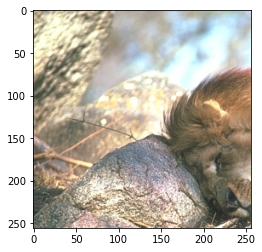

In [40]:
plt.imshow(X[0,:,:,:].detach().permute(1,2,0).cpu().numpy())

In [41]:
Xblur=X+torch.FloatTensor(X.size()).normal_(mean=0, std=7.65/255.).to(X.device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


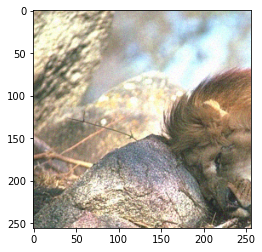

In [42]:
plt.imshow(Xblur[0,:,:,:].detach().permute(1,2,0).cpu().numpy())

In [43]:
from skimage.metrics import peak_signal_noise_ratio as psnr

In [44]:
psnr(X[0,:,:,:].detach().permute(1,2,0).cpu().numpy(),Xblur[0,:,:,:].detach().permute(1,2,0).cpu().numpy())

30.46767408551336

In [45]:
Xdenoise=Xblur-model.grad(Xblur,7.65/255.,False)

In [46]:
psnr(X[0,:,:,:].detach().permute(1,2,0).cpu().numpy(),Xdenoise[0,:,:,:].detach().permute(1,2,0).cpu().numpy())

37.06735283064927

In [47]:
from models.pnp import PNP
from models.deqFixedPoint import DEQFixedPoint,nesterov,simpleIter

In [48]:
model=PNP(10.0,0.1,model,'deblurring').to(device)

In [49]:
from hdf5storage import loadmat

In [50]:
kernels=loadmat('miscs/Levin09.mat')['kernels']
kernel=kernels[0,1]

In [51]:
from torch.nn.functional import conv2d,pad

In [52]:
kernelTensor=torch.tensor(kernel,dtype=torch.float32,device=X.device)
kernelTensor=kernelTensor.unsqueeze(0).unsqueeze(0)
kernelTensor=kernelTensor.expand(X.shape[1],1,kernelTensor.shape[2],kernelTensor.shape[3]).to(device)
degradImg=conv2d(pad(X,(kernelTensor.shape[3]//2,kernelTensor.shape[3]//2,kernelTensor.shape[2]//2,kernelTensor.shape[2]//2),mode='circular'),kernelTensor,groups=3)
noise=torch.FloatTensor(degradImg.size()).normal_(mean=0, std=7.65/255.).to(degradImg.device)
Xblur=degradImg+noise

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


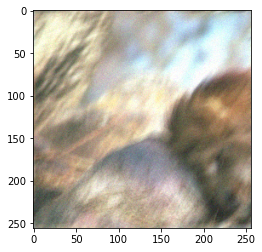

In [53]:
plt.imshow(Xblur[0,:,:,:].detach().permute(1,2,0).cpu().numpy())

In [54]:
model.initialize_prox(Xblur,kernel)

In [55]:
X0=model.calculate_prox(Xblur)

In [56]:
Xrecon=nesterov(lambda z:model(z,13.770,False),X0,50)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


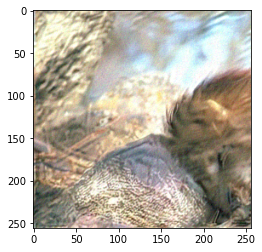

In [57]:
plt.imshow(Xrecon[0,:,:,:].detach().permute(1,2,0).cpu().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


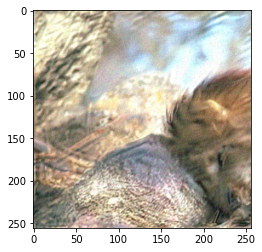

In [58]:
relative_diff_F_min=1e-6
diff_F=1
F_old=1
maxitr=30
i=0
lamb=0.1
tau=10.0
x=X0
while i < maxitr:


    sigma_denoiser = 13.770

    x_old = x

    #Denoising of x_old and calculation of F_old
    x=model(x_old,sigma_denoiser,False)
    i+=1
plt.imshow(x[0,:,:,:].detach().permute(1,2,0).cpu().numpy())
plt.show()

        

        